In [1]:
import numpy as np
import scipy
import scipy.stats as ss
from scipy.stats import logistic
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression




In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 12,4
sb.set_style('whitegrid')

# Import Dataset

In [3]:
address = 'SampleDataSet.csv'
customer_service = pd.read_csv(address)
customer_service.columns = ['asst_id','product_type','mnfture_wk','contract_st','contract_end','contact_wk',
                            'contact_type','issue_type','topic_category','parts_sent','repair_type',
                            'repeat_ct','parts_ct','agent_tenure_indays','contact_manager_flg',
                            'diagnostics','repeat_parts_sent','region','country']
customer_service.head()


,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country
0,0,Laptops,201726,201726,202125,201840,Voice,NaN,NaN,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,NaN,Hogwarts,NaN
1,1,Laptops,201650,201650,201949,201840,Voice,NaN,NaN,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,NaN,Hogwarts,Zonko's Joke Shop
2,2,Laptops,201821,201821,202222,201840,Voice,NaN,NaN,Cables,Hard,0,1,1018.0,0,Not_USED,"Motherboard, Miscellaneous(2), Hard Drive, Cha...",Hogwarts,Zonko's Joke Shop
3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Booting,Hard Drive,Hard,0,1,298.0,0,Effective_Usage,NaN,Hogwarts,Zonko's Joke Shop
4,4,Laptops,201732,201732,202032,201840,Voice,NaN,NaN,Battery (Notebook),Hard,0,1,1018.0,0,Not_USED,NaN,Hogwarts,Zonko's Joke Shop


# Data Preprocessing - Cleaning Data

In [4]:
#Locate data points where "part_sent" is empty and "repeat_parts_sent" is also empty, but "repair_type" is "Hard".
removed_index_1 = customer_service.loc[(customer_service['repair_type'] == 'Hard') & (customer_service['parts_sent'].isnull())
                     & (customer_service['repeat_parts_sent'].isnull())].index
removed_index_1


Int64Index([    7,    10,    31,    55,    64,    95,   115,   124,   178,
              197,
            ...
            99760, 99787, 99816, 99857, 99882, 99895, 99938, 99957, 99962,
            99969],
           dtype='int64', length=4321)

In [5]:
#Locate data points where there is no additional visit but there is part sent out on addtional visit.
removed_index_2 = customer_service.loc[(customer_service['repeat_ct'] == 0) & (customer_service['repeat_parts_sent'].notnull())].index
removed_index_2

Int64Index([    2,    23,    36,    46,    50,    52,    67,    68,   182,
              186,
            ...
            99805, 99864, 99868, 99873, 99898, 99902, 99958, 99990, 99993,
            99996],
           dtype='int64', length=6132)

In [6]:
#Locate data points where there is no information for "agent_tenure_indays".
removed_index_3 = customer_service.loc[customer_service['agent_tenure_indays'].isnull()].index
removed_index_3

Int64Index([ 1696,  2050,  2519,  9989, 11672, 47345, 49209, 72419, 79931,
            84878, 85232, 85701, 93171, 94854],
           dtype='int64')

In [7]:
#Combine 3 indices of above data points to be dropped.
removed_index = (removed_index_1.union(removed_index_2)).union(removed_index_3)
removed_index

Int64Index([    2,     7,    10,    23,    31,    36,    46,    50,    52,
               55,
            ...
            99898, 99902, 99938, 99957, 99958, 99962, 99969, 99990, 99993,
            99996],
           dtype='int64', length=10467)

In [8]:
#Drop the above 3 different types of outliers.
customer_service = customer_service.drop(removed_index)
customer_service.shape

(89533, 19)

# Data Preprocessing - Filling Missing Values

In [9]:
#For columns "parts_sent" and "repeat_part_sent" fill in missing values with keyword "None".
customer_service.update(customer_service[['parts_sent', 'repeat_parts_sent']].fillna('None'))

In [10]:
# For columns like "product_type", "issue_type", "topic_category" etc fill in missing values with keyword "Other".
customer_service.update(customer_service[['product_type', 'issue_type', 'topic_category','region', 
                                          'country']].fillna("Other"))
customer_service.head()

,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country
0,0,Laptops,201726,201726,202125,201840,Voice,Other,Other,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,None,Hogwarts,Other
1,1,Laptops,201650,201650,201949,201840,Voice,Other,Other,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop
3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Booting,Hard Drive,Hard,0,1,298.0,0,Effective_Usage,None,Hogwarts,Zonko's Joke Shop
4,4,Laptops,201732,201732,202032,201840,Voice,Other,Other,Battery (Notebook),Hard,0,1,1018.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop
5,5,Laptops,201137,201137,201237,201840,VOICE,Fee Based Support,General Queries,None,Soft,0,0,802.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop


In [11]:
#Check to make sure no more empty cells are in the data.
customer_service.isna().sum()

asst_id                0
product_type           0
mnfture_wk             0
contract_st            0
contract_end           0
contact_wk             0
contact_type           0
issue_type             0
topic_category         0
parts_sent             0
repair_type            0
repeat_ct              0
parts_ct               0
agent_tenure_indays    0
contact_manager_flg    0
diagnostics            0
repeat_parts_sent      0
region                 0
country                0
dtype: int64

# Creating Additional Column Named "duration_wk"

In [12]:
#Separate the year and week in columns "contract_st" and "contact_wk".
contract_st_str = customer_service['contract_st'].astype(str)
contract_st_yr = contract_st_str.str[0:4].astype(int)
contract_st_wk = contract_st_str.str[4:6].astype(int)

contact_wk_str = customer_service['contact_wk'].astype(str)
contact_yr = contact_wk_str.str[0:4].astype(int)
contact_wk_new = contact_wk_str.str[4:6].astype(int)

#Calculate the duration in weeks between the contract start week and contact week.
duration = (contact_yr - contract_st_yr)*52 + (contact_wk_new - contract_st_wk)

#Add this new column to data frame.
customer_service['duration_wk'] = duration

#Check to see whether there is any negative value for duration in weeks.
customer_service[customer_service['duration_wk'] < 0]
#contact_yr = str(int(customer_service['contact_wk']))


,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country,duration_wk
47,46,Laptops,201844,201844,201945,201840,CHAT,"Audio, Video, Speakers, TV Tuner",Other,None,Soft,0,0,718.0,0,Effective_Usage,None,Hogwarts,Zonko's Joke Shop,-4
213,210,Laptops,201825,201842,201942,201840,VOICE,"Audio, Video, Speakers, TV Tuner",Audio Device,Speaker,Hard,0,1,1635.0,0,Effective_Usage,None,Middle Earth,Lorien,-2
244,241,Laptops,201848,201848,201949,201840,VOICE,"Audio, Video, Speakers, TV Tuner",Graphics Card,"Motherboard, Miscellaneous, Documentation",Hard,1,3,720.0,1,Effective_Usage,"Motherboard, Miscellaneous, Documentation, Cha...",Hogwarts,Zonko's Joke Shop,-8
581,578,Laptops,201902,201902,202002,201840,VOICE,Fee Based Support,Other,None,Soft,0,0,1453.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,-14
609,606,Laptops,201852,201852,202001,201840,VOICE,Fee Based Support,LCD/Monitor,None,Soft,0,0,725.0,0,Not_Considered,None,Hogwarts,Zonko's Joke Shop,-12
898,891,Desktops,201811,201908,202222,201840,VOICE,Power Subsystem / Cables / AC Adapter,Booting,"Power Supply, PCBA - Misc., Motherboard, Docum...",Hard,0,4,2685.0,0,Not_USED,None,Middle Earth,Lorien,-20
917,910,Desktops,201844,201844,201944,201840,CHAT,System Board Components,Other,None,Soft,0,0,718.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,-4
1186,1178,Desktops,201849,201849,202150,201840,VOICE,System Board Components,LCD/Monitor,"Motherboard, Miscellaneous, Documentation",Hard,0,3,879.0,0,Effective_Usage,None,Hogwarts,Zonko's Joke Shop,-9
1261,1251,Laptops,201845,201845,201945,201840,VOICE,System Board Components,Shutdown,"Speaker(2), Motherboard, Documentation",Hard,0,4,436.0,0,Not_USED,None,Middle Earth,Lorien,-5
1374,1362,Laptops,201902,201902,202002,201840,CHAT,Information Status,Call Logs,None,Soft,0,0,330.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,-14


In [13]:
#From the output of last cell, it looks like there were some more recording errors in the data where serice call is made
#before warranty starts.
#For some data points the contact_wk is even before the mnfture_mk. 
#It is not possible for customers to make a service call before their device is made.
#Data point like this will be dropped.
removed_index_4 = customer_service[customer_service['duration_wk'] < 0].index
customer_service = customer_service.drop(removed_index_4)
customer_service.head()

,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country,duration_wk
0,0,Laptops,201726,201726,202125,201840,Voice,Other,Other,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,None,Hogwarts,Other,66
1,1,Laptops,201650,201650,201949,201840,Voice,Other,Other,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,94
3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Booting,Hard Drive,Hard,0,1,298.0,0,Effective_Usage,None,Hogwarts,Zonko's Joke Shop,136
4,4,Laptops,201732,201732,202032,201840,Voice,Other,Other,Battery (Notebook),Hard,0,1,1018.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,60
5,5,Laptops,201137,201137,201237,201840,VOICE,Fee Based Support,General Queries,None,Soft,0,0,802.0,0,Not_USED,None,Hogwarts,Zonko's Joke Shop,367


Text(0, 0.5, 'Probability Component Will Survive')

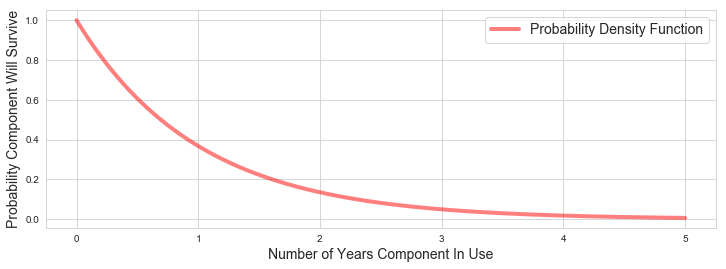

In [14]:
# Plot exponential distribution function for documentation purpose only.
def plot_exponential(x_range, mu=1/150, sigma=1/150, cdf=False, **kwargs):
    x = x_range
    if cdf:
        y = ss.expon.cdf(x, mu, sigma)
    else:
        y = ss.expon.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)

x = np.linspace(0, 5, 5000)

plot_exponential(x, 0, 1, color='red', lw=4, ls='-', alpha=0.5, label='Probability Density Function')
plt.legend(fontsize=14);
plt.xlabel('Number of Years Component In Use', fontsize=14)
plt.ylabel('Probability Component Will Survive', fontsize=14)

# Random Forests to Predict Number of Additional Visits 

In [15]:
#Separate columns into indenpendent variable set X and repsonse variable Y. 
#First choose "repeat_ct" as Y response and the rest of columns as X indepedent variables excluding "asst_id".

X = customer_service[['product_type','mnfture_wk','contract_st','contract_end','contact_wk',
                      'contact_type','issue_type','topic_category','parts_sent','repair_type',
                      'parts_ct','agent_tenure_indays','contact_manager_flg','diagnostics',
                      'repeat_parts_sent','region','country', 'duration_wk']]
Y = customer_service['repeat_ct']

#Since there are many string variables in the data that cannot be accepted by the classification algorithm, 
#we will encode these variables into integers first and save the encoding information in a dictionary.
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
        

C:\Users\rocky\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


{'Desktops': 0, 'Laptops': 1, 'Other': 2, 'Other Electronics': 3}
{'CHAT': 0, 'EMAIL': 1, 'Unknown': 2, 'VOICE': 3, 'Voice': 4}
{'Adobe': 0, 'Audio, Video, Speakers, TV Tuner': 1, 'Backplane': 2, 'Backup / Archive / Data Management': 3, 'Backup / Recovery Software': 4, 'Battery / CMOS': 5, 'Battery/CMOS': 6, 'Burn, Playback, Audio': 7, 'CFA, MFA (Customer or Manufacturer) Field Action': 8, 'Cancel & Rebook': 9, 'Changed Mind': 10, 'Clinic': 11, 'Communication/Networking': 12, 'Compellent - Hardware': 13, 'Compellent - NAS / zNAS / FS8600': 14, 'Compellent - Non-Compellent': 15, 'Compellent - Software': 16, 'Contract or Service Issue': 17, 'Controller / Controller Card': 18, 'Credits': 19, 'Customer': 20, 'Customer Concession': 21, 'Customer Confirmed CID': 22, 'Customer Related Issue': 23, 'DDPE Locally Managed': 24, 'DDPE Remotely Managed': 25, 'Damaged': 26, 'Dell EMC/EQL Software': 27, 'Dell Mobile / Wireless Devices': 28, 'Dell Mobile Devices': 29, 'Dell Net Ready': 30, 'Dell OM Co

{'Acrux': 0, 'Alcor': 1, 'Aldebaran': 2, 'Altair': 3, 'Antares': 4, 'Arcturus': 5, 'Becrux': 6, 'Bellatrix': 7, 'Betelgeuse': 8, 'Bree': 9, 'Canopus': 10, 'Capella': 11, 'Castor': 12, 'Diagon Alley': 13, 'Erebor': 14, 'Fangorn': 15, 'Fomalhaut': 16, 'Gondor': 17, 'Gryffindor': 18, "Helm's Deep": 19, 'Hobbiton': 20, "Hog's Head Inn": 21, "Honeyduke's": 22, 'Hufflepuff': 23, 'Isengard': 24, 'Lorien': 25, 'Merope': 26, 'Minas Tirith': 27, 'Mintaka': 28, 'Mirkwood': 29, 'Mizar': 30, 'Mordor': 31, 'Moria': 32, 'Muscida': 33, 'Other': 34, 'Pleione': 35, 'Polaris': 36, 'Pollux': 37, 'Procyon': 38, 'Ravenclaw': 39, 'Regulus': 40, 'Rigel': 41, 'Rohan': 42, 'Sabik': 43, 'Shrieking Shack': 44, 'Sirius': 45, 'Slytherin': 46, 'Spica': 47, 'The Shire': 48, 'Three Broomsticks': 49, 'Vega': 50, "Zonko's Joke Shop": 51}


In [16]:
#Split the data set into training set (70%) and test set (30%).
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

print('Training Independent Shape:',X_train.shape)
print('Training Repsonse Shape:', Y_train.shape)
print('Testing Independent Shape:', X_test.shape)
print('Testing Response:', Y_test.shape)

Training Independent Shape: (62169, 18)
Training Repsonse Shape: (62169,)
Testing Independent Shape: (26645, 18)
Testing Response: (26645,)


In [20]:
#Create a Random Forests classifier with 1,000 bootstrap samples.
clf = RandomForestClassifier(n_estimators = 1000, random_state = 0)

#Train the model using training data set.
clf.fit(X_train,Y_train)

#Once model building is completed make prediction on "repeat_ct" using test data set.
#Y_pred is an array of the predicted classes for all the data points in test data set.
Y_pred=clf.predict(X_test)

# Print out model accuracy.
print("Accuracy of Predicting Number of Additional Visits Required to Fix The Problem:",metrics.accuracy_score(Y_test, Y_pred))


Accuracy of Predicting Number of Additional Visits Required to Fix The Problem: 0.9983111277913305


In [30]:
Y_test.unique()

array([0, 1, 2, 3], dtype=int64)

ValueError: multiclass format is not supported

In [18]:
#Compare the first 10 observed "repeat_ct" values with those predicted by this model.
Y_test[0:10,]

2168     0
44737    0
36296    0
56611    0
53993    0
49843    0
83983    1
517      0
88569    0
31284    1
Name: repeat_ct, dtype: int64

In [19]:
list(Y_pred[0:10])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]

# Predicting Parts Count by Random Forests

In [20]:
#Next step is to predict parts count, "parts_ct", with the same strategy above when predicting "repeat_ct".
#Therefore, the majority of the code below for predicting "parts_ct" will be the same as above for "repeat_ct".
#"part_ct" will be the response variable and the rest of the columns will be independent variables except "asst_id".

X = customer_service[['product_type','mnfture_wk','contract_st','contract_end','contact_wk',
                      'contact_type','issue_type','topic_category','parts_sent','repair_type',
                      'repeat_ct','agent_tenure_indays','contact_manager_flg','diagnostics',
                      'repeat_parts_sent','region','country', 'duration_wk']]
Y = customer_service['parts_ct']

#Since there are many string variables in the data that cannot be accepted by the classification algorithm, 
#we will encode these variables into integers first and save the encoding information in a dictionary.
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        #print(le_name_mapping)




C:\Users\rocky\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [21]:
#check to see how many unique values in "parts_ct".
np.unique(customer_service['parts_ct'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 28, 29, 46, 48, 50, 51], dtype=int64)

In [22]:
#Split the data set into training set (70%) and test set (30%).
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

print('Training Independent Shape:',X_train.shape)
print('Training Repsonse Shape:', Y_train.shape)
print('Testing Independent Shape:', X_test.shape)
print('Testing Response:', Y_test.shape)

Training Independent Shape: (62169, 18)
Training Repsonse Shape: (62169,)
Testing Independent Shape: (26645, 18)
Testing Response: (26645,)


In [23]:
#Create a Random Forests classifier with 1,000 bootstrap samples.
clf = RandomForestClassifier(n_estimators = 1000, random_state = 0)

#Train the model using training data set.
clf.fit(X_train,Y_train)

#Once model building is completed make prediction on "repeat_ct" using test data set.
#Y_pred is an array of the predicted classes for all the data points in test data set.
Y_pred=clf.predict(X_test)

# Print out model accuracy.
print("Accuracy of Predicting Number of Parts Sent to Fix The Problem:",metrics.accuracy_score(Y_test, Y_pred))


Accuracy of Predicting Number of Parts Sent to Fix The Problem: 0.9224620003753049


In [33]:
np.unique(Y_pred)

array([0, 1], dtype=int64)

In [34]:
#Investigate the variable importance and see if we can improve the model.
variable_importance = pd.Series(clf.feature_importances_,index=list(X.columns.values)).sort_values(ascending=False)
variable_importance

repeat_parts_sent      0.861500
repair_type            0.031259
parts_ct               0.024692
parts_sent             0.019119
contract_end           0.009307
issue_type             0.008875
agent_tenure_indays    0.007663
mnfture_wk             0.007074
contract_st            0.006541
duration_wk            0.006464
topic_category         0.004458
diagnostics            0.003117
country                0.002953
contact_type           0.002590
product_type           0.002091
region                 0.001886
contact_manager_flg    0.000411
contact_wk             0.000000
dtype: float64

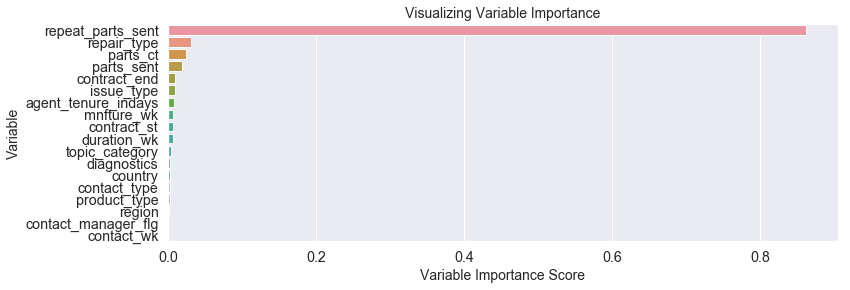

In [35]:
#Plot the variable importance in bar chart with Seaborn.
sb.set(font_scale=1.3)
sb.barplot(x=variable_importance, y=variable_importance.index)
plt.xlabel('Variable Importance Score', fontsize = 14)
plt.ylabel('Variable', fontsize = 14)
plt.title("Visualizing Variable Importance", fontsize = 14)
plt.show()

In [36]:
#Retrain the model after removing the 4 least important variables observed from the bar plot above.
#Exclude "contact_wk", "contact_manager_flg", "repeat_ct", "region".

X = customer_service[['product_type','mnfture_wk','contract_st','contract_end',
                      'contact_type','issue_type','topic_category','parts_sent','repair_type',
                      'agent_tenure_indays', 'diagnostics',
                      'repeat_parts_sent','country', 'duration_wk']]
Y = customer_service['parts_ct']

for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        #print(le_name_mapping)



C:\Users\rocky\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

#Create a Random Forests classifier with 1,000 bootstrap samples.
clf = RandomForestClassifier(n_estimators = 1000, random_state = 0)

#Train the model using training data set.
clf.fit(X_train,Y_train)

#Once model building is completed make prediction on "repeat_ct" using test data set.
#Y_pred is an array of the predicted classes for all the data points in test data set.
Y_pred=clf.predict(X_test)

# Print out model accuracy.
print("Accuracy of Predicting Number of Parts Sent to Fix The Problem:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy of Predicting Number of Parts Sent to Fix The Problem: 0.9216738600112592


In [38]:
#Removing the least important variables does not improve the model.
#Let us move onto the next tipic.


# Logistic Regression - Predicting Contact Manager Flag

Text(0, 0.5, 'Probability of Dependent Variable')

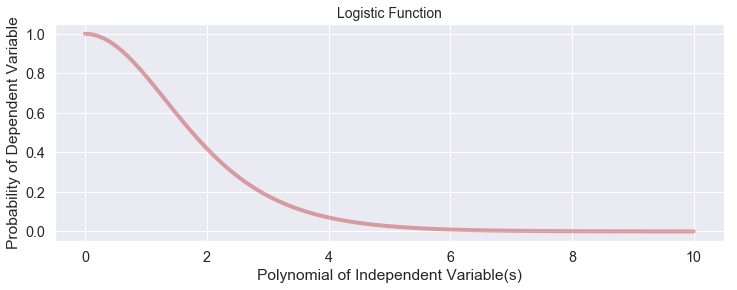

In [39]:
#Plot logistic function for documentation purpose only.
x = np.linspace(0,10, 100)
plt.plot(x, 4*logistic.pdf(x),'r-', lw=4, alpha=0.5)
plt.title('Logistic Function', fontsize=14)
plt.xlabel('Polynomial of Independent Variable(s)')
plt.ylabel('Probability of Dependent Variable')

In [40]:
#Separate columns into indenpendent variable set X and repsonse variable Y. 
#Choose "contact_manager_flg" as Y response variable and the rest of columns as X independent variables excluding "asst_id".

X = customer_service[['product_type','mnfture_wk','contract_st','contract_end','contact_wk',
                      'contact_type','issue_type','topic_category','parts_sent','repair_type',
                      'repeat_ct','parts_ct','agent_tenure_indays','diagnostics',
                      'repeat_parts_sent','region','country', 'duration_wk']]
Y = customer_service['contact_manager_flg']

#Encode string variables into integers to feed into Logistic Regression algorithm.
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        #print(le_name_mapping)


C:\Users\rocky\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
#Split the data set into training set (70%) and test set (30%).
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)


In [42]:
#Instantiate a Logistic Regression object with default parameters.
logreg = LogisticRegression()

# Fit the model with training data set.
logreg.fit(X_train,Y_train)

#Once Logistic Regression is ready make prediction using the test data set.
Y_pred=logreg.predict(X_test)


# Print out model accuracy.
print("Accuracy of Predicting Contact Manager Flag:",metrics.accuracy_score(Y_test, Y_pred))


C:\Users\rocky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Predicting Contact Manager Flag: 0.9872021017076374


In [43]:
#Print out the Confusion Matrix.
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
cnf_matrix

array([[26304,     0],
       [  341,     0]], dtype=int64)

Text(0.5, 510.88, 'Predicted Contact Manager Flag')

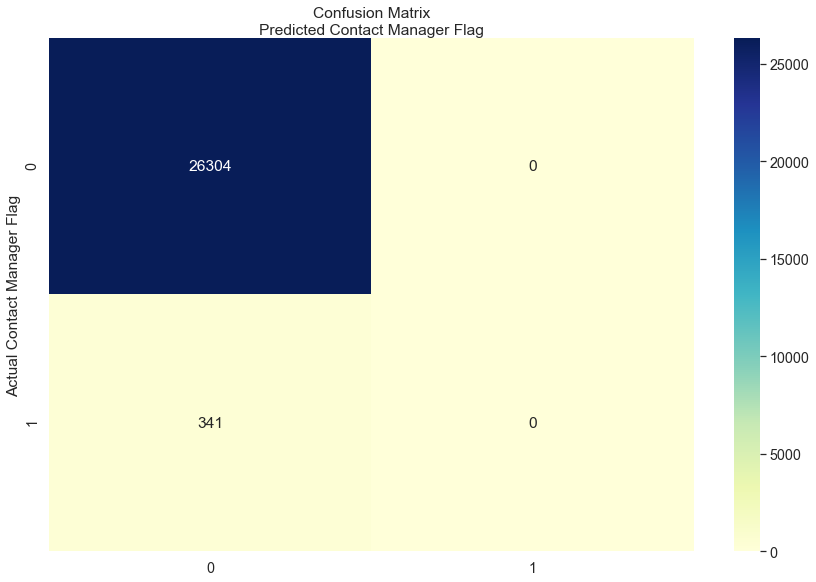

In [52]:
#Plot Confusion Matrix in a Heatmap. 
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Contact Manager Flag')
plt.xlabel('Predicted Contact Manager Flag')

In [56]:
# Since it is imbalanced classification it is more appropriate to look at the AUC value
# Calculate the class probabilities for label "1"
logreg_probs = logreg.predict_proba(X_test)[:, 1]
# Calculate ROC AUC
auc_value = metrics.roc_auc_score(Y_test, logreg_probs)

print("The ROC-AUC value for Logistic Regression classifier is :",auc_value)

The ROC-AUC value for Logistic Regression classifier is : 0.7116352964837925


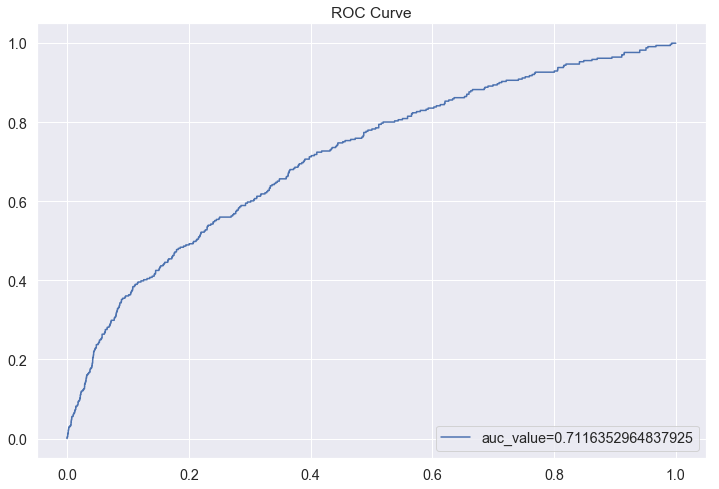

In [54]:
# Plot ROC-AUC curve
rcParams['figure.figsize'] = 12,8
fpr, tpr, _ = metrics.roc_curve(Y_test,  logreg_probs)
plt.plot(fpr,tpr,label="auc_value="+str(auc_value))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

# Thank you!